# Homework 6, Problem 4 - Particle filter
You will change the observation model (cell 6) and the observation probability (cell 10) to make
this particle filter simulation have Poisson observations instead of Gaussian.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns

In [2]:
np.random.seed(0)

In [3]:
# 1-D state dynamics
def state_dynamics(z):
    return z + np.random.randn(*z.shape)

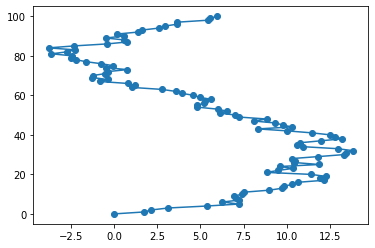

In [4]:
# Generate a random simulation of our latent state dynamics
z = [np.array(0)]
t = [0]
for i in range(100):
    z.append(state_dynamics(z[-1]))
    t.append(i+1)

plt.plot(z,t,'-o')

In [5]:
## For our observations, we will define Place Fields with Gaussian-like receptive fields 
NumberOfNeurons = 20
PF_Centers = np.random.rand(NumberOfNeurons) * 100 # Place fields center between 0 and 100
PF_Max = 10 # Maximum firing rate
PF_Width = 25 # Width or fall off in space of Place fields

def mean_rate(z):
    return np.exp(-((z - PF_Centers)/PF_Width)**2) * PF_Max

In the following cell, we changed the observation to be Poisson.

In [6]:
###
### For homework you will change this to Poisson!
###

## For Gaussian model, we need a standard deviation per neuron
Gaussian_PF_Noise_Variance = 10
def observation_gaussian(z, innovation_factor=1):
    # Additive Gaussian noise. Change this to Poisson!
    return mean_rate(z) + innovation_factor*np.random.randn(len(PF_Centers))*np.sqrt(Gaussian_PF_Noise_Variance)


# Randomly generate an observation from neurons
def observation_poisson(z):
    # Additive Poisson noise.
    return np.random.poisson(lam=mean_rate(z)) # lambda is the mean_rate of z

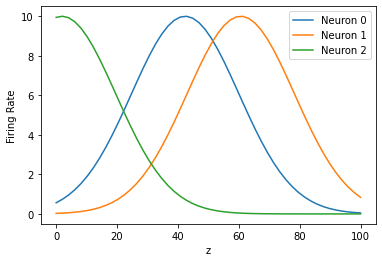

In [7]:
# Plot some example receptive fields
z = np.linspace(0,100)
nn = np.array([mean_rate(z_) for z_ in z])
plt.plot(z,nn[:,0], label='Neuron 0')
plt.plot(z,nn[:,1], label='Neuron 1')
plt.plot(z,nn[:,2], label='Neuron 2')
plt.gca().set_ylabel('Firing Rate')
plt.gca().set_xlabel('z')
plt.legend()
plt.show()

In [8]:
# Here's the trajectory we will try to decode
Trajectory = np.linspace(0,100,num=101)

In [9]:
# Here's the neural activity corresponding to our trajectory

Neural_Activity_gaussian = np.array([observation_gaussian(z) for z in Trajectory])
Neural_Activity_poisson = np.array([observation_poisson(z) for z in Trajectory])

In the following cell, we also chenged the ``p_observation`` to be Poisson.

In [10]:

###
### Homework - Modify this to be Poisson!
### 
    
def p_observation_gaussian(x, z):
    # Quick way of calculating Multivariate normal with uncorrelated dimensions
    # Calculate the product across neurons as exp( sum (log_probabilities) )
    
    # Gaussian
    return np.exp(scipy.stats.norm.logpdf(x, mean_rate(z), np.sqrt(Gaussian_PF_Noise_Variance)).sum())

def p_observation_poisson(x, z):
    # Quick way of calculating Multivariate normal with uncorrelated dimensions
    # Calculate the product across neurons as exp( sum (log_probabilities) )
    
    # Poisson
    return np.exp(scipy.stats.poisson.logpmf(x, mean_rate(z)).sum())

In [11]:
# Run the particle filter
def particle_filter(p_observation, Neural_Activity, N=100): # The number of particles will also be a variable
    Z = []
    I = []
    Z_ = []
    W = []


    # Start by sampling initial distribution, N(0,10)
    # Generate N particles corresponding to time 0
    Z.append(np.random.randn(N)*np.sqrt(10))

    ### In python Z[-1] refers to the last item in a list or vector

    for i in range(101):
        # Calculate a posteriori probability for each particle
        APosterioriProb = np.array([p_observation(Neural_Activity[i,:],z) for z in Z[-1]])
        # Normalize probabilities to get a weight vector
        W.append(APosterioriProb / APosterioriProb.sum())
        # Sample particles using weights - I[] keeps track of the indices chosen
        #  we could do it more efficiently like this:
        #      z_ =  np.random.choice(Z[-1],size=N,replace=True,p=W[-1])
        idx =  np.random.choice(N,size=N,replace=True,p=W[-1])
        I.append(idx)
        z_ = Z[-1][idx]
        Z_.append(z_)
        # Step forward in time by sampling from the dynamics
        Z.append( state_dynamics(z_) )
        
    # For plotting the distribution of particles at a particular time step
    t = 50
    pp = np.array([p_observation(Neural_Activity[t,:],z) for z in Z[t]])
    pp = pp / pp.sum()

    return pp, z, Z, Z_, t, W, N

In [12]:
pp, z, Z, Z_, t, W, N = particle_filter(p_observation_poisson, Neural_Activity_poisson)

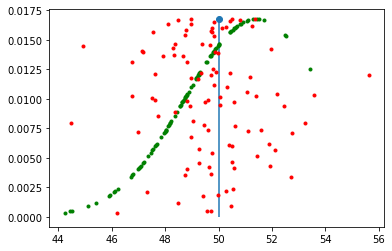

In [13]:
plt.plot(Z[t], pp,'g.')
plt.plot(Z[t+1], pp,'r.')
plt.stem([Trajectory[t]], [np.max(W[t])])
plt.show()

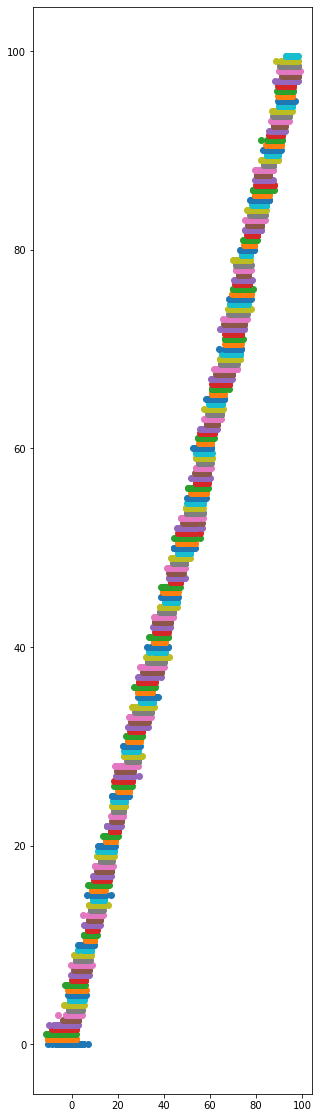

In [14]:
fig, ax = plt.subplots(1,1,figsize=(5,20))
for i in range(100):
    ax.plot(Z[i], i*np.ones(N), 'o')
    ax.plot(Z_[i], i*np.ones(N)+0.5, 'o')

MSE = 4.675923551186773


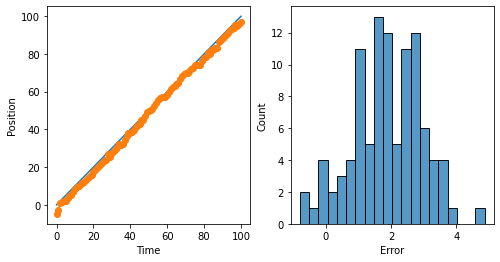

In [15]:
# Calculate estimated trajectory

Z_ = np.array(Z)
W_ = np.array(W)

EstimatedTrajectory = np.sum(Z_[:-1] * W_[:], axis=1)


# Plot estimated trajectory and error histogram
fig, axs = plt.subplots(1, 2, figsize=(8,4))

axs[0].plot(Trajectory)
axs[0].plot(EstimatedTrajectory, '-o')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Position')

Error = (Trajectory - EstimatedTrajectory)

sns.histplot(Error, ax=axs[1], bins=20, kde=False)
axs[1].set_xlabel('Error')
print('MSE = {}'.format(np.mean(Error**2)))

#### Commentary - notice that the error is strongly biased. This is because the animal is moving further 
####   each timestep than would be likely for a N(0,1) random walk. Try changing the "speed" of the animal
####   to 0.5 or 0.1 cm per time step and see if the error is still biased.


We want to generate a cycle that runs, say 10 times for Poisson and 10 times for Gaussian so we can compare MSE values

MSE = 4.434706786845835
MSE = 3.5983500013364735
MSE = 4.2091261420687545
MSE = 4.532533915094543
MSE = 4.220584499266369
MSE = 3.7495315008050976
MSE = 4.180653648504263
MSE = 4.157475851837768
MSE = 4.031033160134049
MSE = 4.3533403504125685


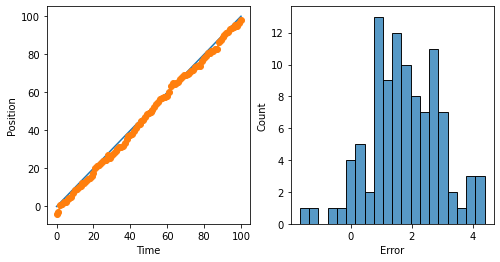

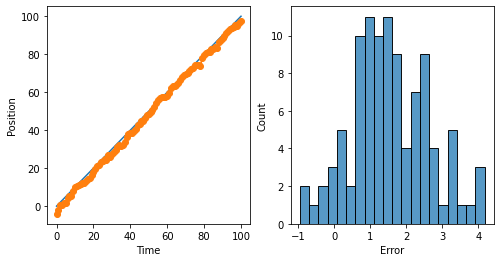

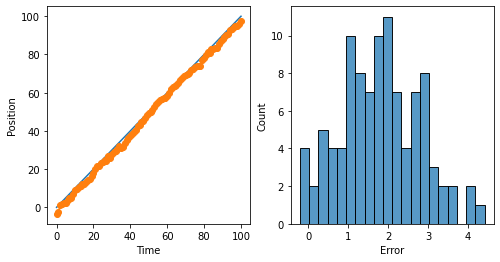

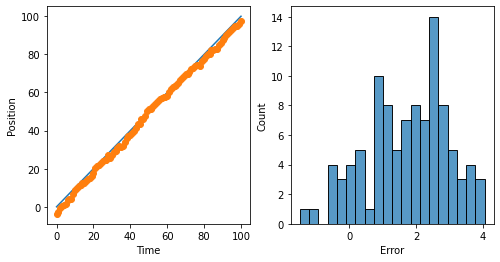

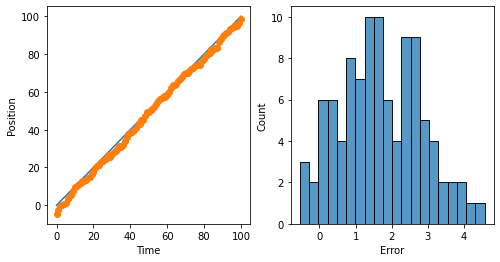

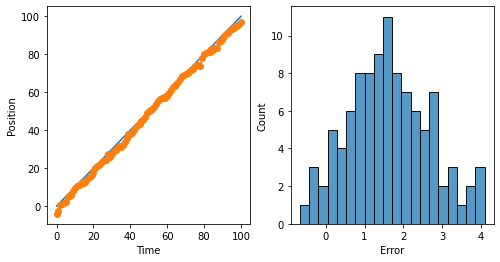

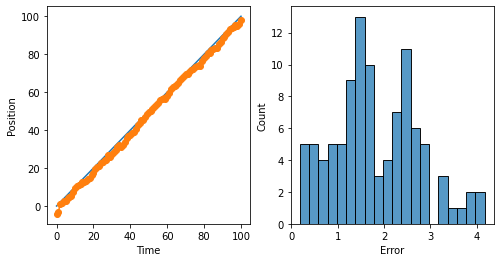

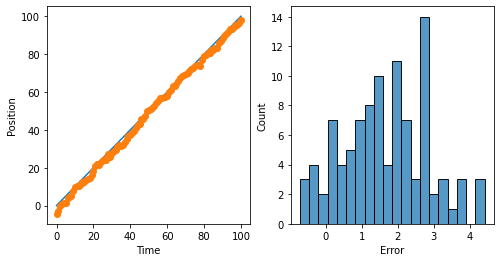

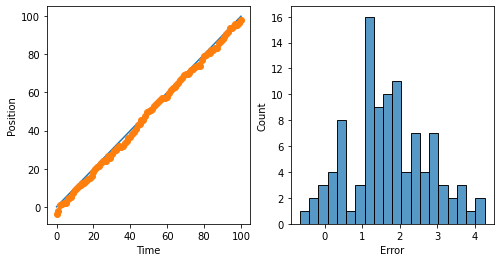

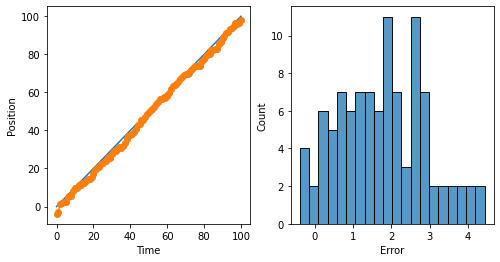

In [16]:
# Poisson cycle
iterations = 3
MSE_poisson = np.zeros(iterations)
# MSE_gaussian = np.zeros(iterations)

for i in range(iterations):
    pp, z, Z, Z_, t, W, N = particle_filter(p_observation_poisson, Neural_Activity_poisson)

    # Calculate estimated trajectory

    Z_ = np.array(Z)
    W_ = np.array(W)

    EstimatedTrajectory = np.sum(Z_[:-1] * W_[:], axis=1)


    # Plot estimated trajectory and error histogram
    fig, axs = plt.subplots(1, 2, figsize=(8,4))

    axs[0].plot(Trajectory)
    axs[0].plot(EstimatedTrajectory, '-o')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Position')

    Error = (Trajectory - EstimatedTrajectory)

    sns.histplot(Error, ax=axs[1], bins=20, kde=False)
    axs[1].set_xlabel('Error')
    print('MSE = {}'.format(np.mean(Error**2)))
    MSE_poisson[i] = np.mean(Error**2)

MSE = 17.710804718143887
MSE = 15.094691975848216
MSE = 16.504857436135506
MSE = 19.653055836373145
MSE = 13.963588436396952
MSE = 15.146542478105292
MSE = 16.336788124251918
MSE = 16.925758369011408
MSE = 15.727253040778445
MSE = 17.31071443860848


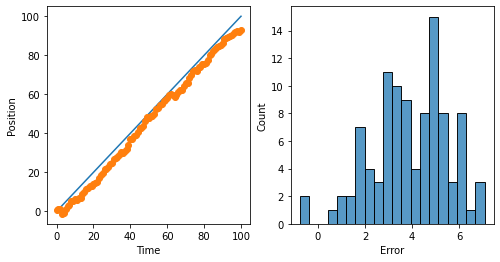

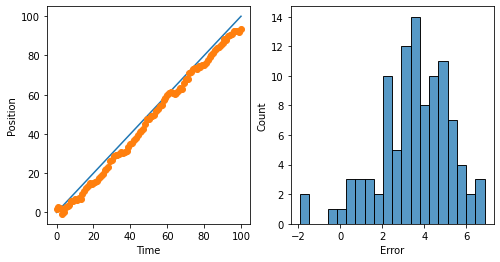

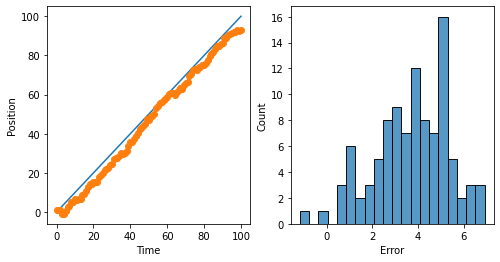

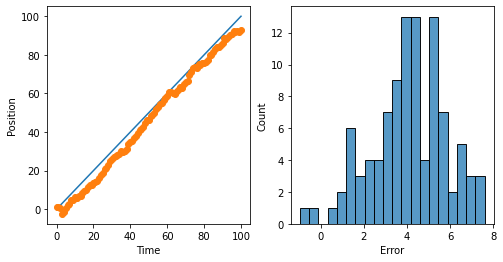

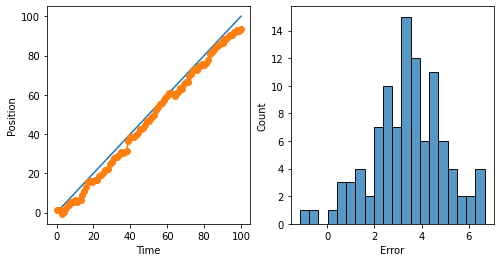

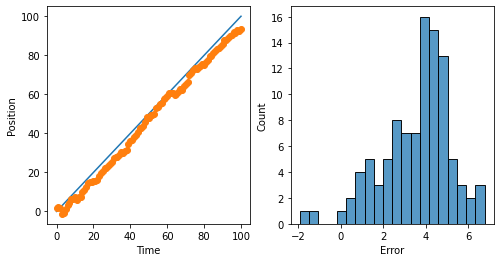

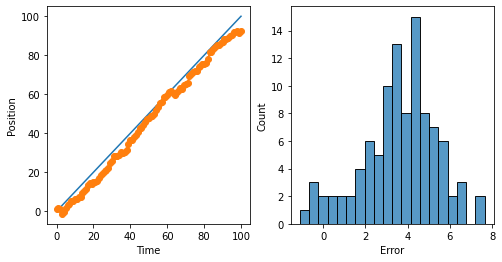

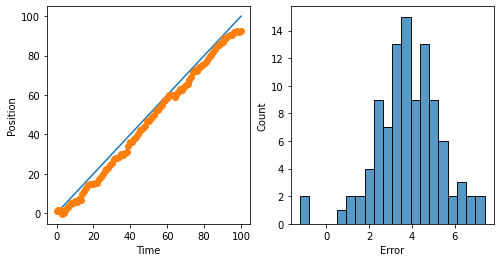

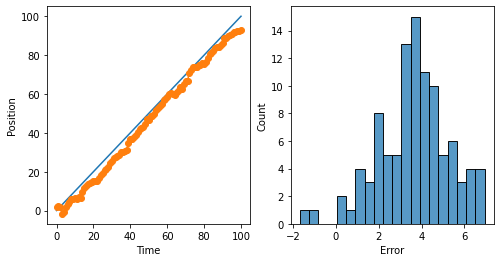

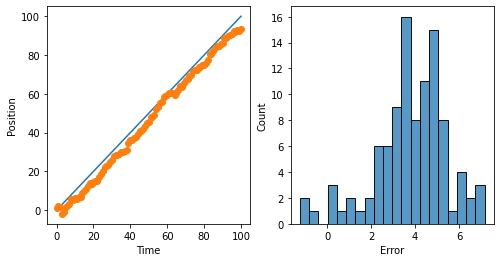

In [17]:
# Gaussian cycle
iterations = 3
MSE_gaussian = np.zeros(iterations)

for i in range(iterations):
    pp, z, Z, Z_, t, W, N = particle_filter(p_observation_gaussian, Neural_Activity_gaussian)

    # Calculate estimated trajectory

    Z_ = np.array(Z)
    W_ = np.array(W)

    EstimatedTrajectory = np.sum(Z_[:-1] * W_[:], axis=1)


    # Plot estimated trajectory and error histogram
    fig, axs = plt.subplots(1, 2, figsize=(8,4))

    axs[0].plot(Trajectory)
    axs[0].plot(EstimatedTrajectory, '-o')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Position')

    Error = (Trajectory - EstimatedTrajectory)

    sns.histplot(Error, ax=axs[1], bins=20, kde=False)
    axs[1].set_xlabel('Error')
    print('MSE = {}'.format(np.mean(Error**2)))
    MSE_gaussian[i] = np.mean(Error**2)

In [18]:
print("Mean gaussian: ",np.mean(MSE_gaussian))
print("Mean poisson: ",np.mean(MSE_poisson))

Mean gaussian:  16.437405485365325
Mean poisson:  4.146733585630573


Notice how the mean standard error in the gaussian observations are higher compared to the poisson ones.

# FALTA! Is this what you expected?
How could you change the Gaussian model to reduce its MSE?

One way of achiving this would be by diminishing the Gaussian_PF_Noise_Variance because right now it is set to 10, but we could lower it.

b. Experiment with the number of neurons and the maximum firing rates. How does the error change if the number of neurons decreases or increases by a factor of 2? How does the error change if the maximum firing rate decreases or increases by a factor of 2?

c. Experiment with the number of particles. How does the error change if the number of particles used for simulation changes by a factor of 10 (i.e., 10, 100, or 1000)?

d. Experiment with the state dynamics model. What happens to the error if the standard deviation of the “innovation” (the noise term added to the state at each time step) increases or decreases by a factor of 2?

In [19]:
# Doubling the number of neurons

## For our observations, we will define Place Fields with Gaussian-like receptive fields 
NumberOfNeurons = 40 # Originally, there were 20 neurons
PF_Centers = np.random.rand(NumberOfNeurons) * 100 # Place fields center between 0 and 100

z = np.linspace(0,100)
nn = np.array([mean_rate(z_) for z_ in z])

# Here's the trajectory we will try to decode
Trajectory = np.linspace(0,100,num=101)

# Here's the neural activity corresponding to our trajectory
Neural_Activity_gaussian = np.array([observation_gaussian(z) for z in Trajectory])
Neural_Activity_poisson = np.array([observation_poisson(z) for z in Trajectory])

# Poisson cycle
iterations = 3
MSE_poisson_2neurons = np.zeros(iterations)
MSE_gaussian_2neurons = np.zeros(iterations)

for i in range(iterations):
    pp, z, Z, Z_, t, W, N = particle_filter(p_observation_poisson, Neural_Activity_poisson)

    # Calculate estimated trajectory

    Z_ = np.array(Z)
    W_ = np.array(W)

    EstimatedTrajectory = np.sum(Z_[:-1] * W_[:], axis=1)
    Error = (Trajectory - EstimatedTrajectory)

    sns.histplot(Error, ax=axs[1], bins=20, kde=False)
    axs[1].set_xlabel('Error')
    print('MSE = {}'.format(np.mean(Error**2)))
    MSE_poisson_2neurons[i] = np.mean(Error**2)


# Gaussian cycle
for i in range(iterations):
    pp, z, Z, Z_, t, W, N = particle_filter(p_observation_gaussian, Neural_Activity_gaussian)

    # Calculate estimated trajectory

    Z_ = np.array(Z)
    W_ = np.array(W)

    EstimatedTrajectory = np.sum(Z_[:-1] * W_[:], axis=1)
    Error = (Trajectory - EstimatedTrajectory)

    sns.histplot(Error, ax=axs[1], bins=20, kde=False)
    axs[1].set_xlabel('Error')
    print('MSE = {}'.format(np.mean(Error**2)))
    MSE_gaussian_2neurons[i] = np.mean(Error**2)
    
print("Mean gaussian: ",np.mean(MSE_gaussian_2neurons))
print("Mean poisson: ",np.mean(MSE_poisson_2neurons))

MSE = 2.724913006569363
MSE = 3.109064720784486
MSE = 2.738412347660476
MSE = 2.9393337703193696
MSE = 2.9083869123987367
MSE = 2.6314782693714553
MSE = 2.595566770632393
MSE = 2.8747988429454523
MSE = 2.825884479952999
MSE = 2.7788984307283675
MSE = 6.396181580951614
MSE = 6.800965720304243
MSE = 5.419750557577817
MSE = 7.779254728582323
MSE = 7.179848819945133
MSE = 5.893190130762031
MSE = 6.520432440522377
MSE = 6.129928536112595
MSE = 6.069784797412601
MSE = 7.174426235288185
Mean gaussian:  6.536376354745892
Mean poisson:  2.81267375513631


In [20]:
# Doubling the firing rate

## For our observations, we will define Place Fields with Gaussian-like receptive fields 
NumberOfNeurons = 20 
PF_Centers = np.random.rand(NumberOfNeurons) * 100 # Place fields center between 0 and 100

z = np.linspace(0,100)
nn = np.array([2*mean_rate(z_) for z_ in z]) # Doubling the firing rate

# Here's the trajectory we will try to decode
Trajectory = np.linspace(0,100,num=101)

# Here's the neural activity corresponding to our trajectory
Neural_Activity_gaussian = np.array([observation_gaussian(z) for z in Trajectory])
Neural_Activity_poisson = np.array([observation_poisson(z) for z in Trajectory])

# Poisson cycle
iterations = 3
MSE_poisson_2firing = np.zeros(iterations)
MSE_gaussian_2firing = np.zeros(iterations)

for i in range(iterations):
    pp, z, Z, Z_, t, W, N = particle_filter(p_observation_poisson, Neural_Activity_poisson)

    # Calculate estimated trajectory

    Z_ = np.array(Z)
    W_ = np.array(W)

    EstimatedTrajectory = np.sum(Z_[:-1] * W_[:], axis=1)
    Error = (Trajectory - EstimatedTrajectory)

    sns.histplot(Error, ax=axs[1], bins=20, kde=False)
    axs[1].set_xlabel('Error')
    print('MSE = {}'.format(np.mean(Error**2)))
    MSE_poisson_2firing[i] = np.mean(Error**2)


# Gaussian cycle
for i in range(iterations):
    pp, z, Z, Z_, t, W, N = particle_filter(p_observation_gaussian, Neural_Activity_gaussian)

    # Calculate estimated trajectory

    Z_ = np.array(Z)
    W_ = np.array(W)

    EstimatedTrajectory = np.sum(Z_[:-1] * W_[:], axis=1)
    Error = (Trajectory - EstimatedTrajectory)

    sns.histplot(Error, ax=axs[1], bins=20, kde=False)
    axs[1].set_xlabel('Error')
    print('MSE = {}'.format(np.mean(Error**2)))
    MSE_gaussian_2firing[i] = np.mean(Error**2)
    
print("Mean gaussian: ",np.mean(MSE_gaussian_2firing))
print("Mean poisson: ",np.mean(MSE_poisson_2firing))

MSE = 5.764231405873996
MSE = 5.675460153188539
MSE = 6.37022999492607
MSE = 6.557738482879261
MSE = 4.749338279708072
MSE = 5.827829806861557
MSE = 6.4642625013925965
MSE = 5.465213287828111
MSE = 6.142802195028917
MSE = 5.978173792693563
MSE = 13.464341575915928
MSE = 19.306015939457062
MSE = 17.7232380156023
MSE = 20.536753984718793
MSE = 14.933820485625374
MSE = 20.709594556494338
MSE = 19.486004497957648
MSE = 12.146232083671332
MSE = 16.025181412912
MSE = 18.17092192451263
Mean gaussian:  17.250210447686744
Mean poisson:  5.8995279900380675


In [21]:
# Multiplying the number of particles by a factor of 10

## For our observations, we will define Place Fields with Gaussian-like receptive fields 
NumberOfNeurons = 20 
PF_Centers = np.random.rand(NumberOfNeurons) * 100 # Place fields center between 0 and 100

z = np.linspace(0,100)
nn = np.array([2*mean_rate(z_) for z_ in z]) # Doubling the firing rate

# Here's the trajectory we will try to decode
Trajectory = np.linspace(0,100,num=101)

# Here's the neural activity corresponding to our trajectory
Neural_Activity_gaussian = np.array([observation_gaussian(z) for z in Trajectory])
Neural_Activity_poisson = np.array([observation_poisson(z) for z in Trajectory])

# Poisson cycle
iterations = 3
MSE_poisson_10factor = np.zeros(iterations)
MSE_gaussian_10factor = np.zeros(iterations)

for i in range(iterations):
    pp, z, Z, Z_, t, W, N = particle_filter(p_observation_poisson, Neural_Activity_poisson, 1000) #originally 100 particles

    # Calculate estimated trajectory

    Z_ = np.array(Z)
    W_ = np.array(W)

    EstimatedTrajectory = np.sum(Z_[:-1] * W_[:], axis=1)
    Error = (Trajectory - EstimatedTrajectory)

    sns.histplot(Error, ax=axs[1], bins=20, kde=False)
    axs[1].set_xlabel('Error')
    print('MSE = {}'.format(np.mean(Error**2)))
    MSE_poisson_10factor[i] = np.mean(Error**2)


# Gaussian cycle
for i in range(iterations):
    pp, z, Z, Z_, t, W, N = particle_filter(p_observation_gaussian, Neural_Activity_gaussian, 1000) #Originally 100

    # Calculate estimated trajectory

    Z_ = np.array(Z)
    W_ = np.array(W)

    EstimatedTrajectory = np.sum(Z_[:-1] * W_[:], axis=1)
    Error = (Trajectory - EstimatedTrajectory)

    sns.histplot(Error, ax=axs[1], bins=20, kde=False)
    axs[1].set_xlabel('Error')
    print('MSE = {}'.format(np.mean(Error**2)))
    MSE_gaussian_10factor[i] = np.mean(Error**2)
    
print("Mean gaussian: ",np.mean(MSE_gaussian_10factor))
print("Mean poisson: ",np.mean(MSE_poisson_10factor))

MSE = 5.131201330805651
MSE = 5.496066523969881
MSE = 5.453345299002488
MSE = 5.27211089471185
MSE = 5.034494221050029
MSE = 5.338448167790934
MSE = 5.079560955262916
MSE = 5.476240665075717
MSE = 5.555124578892338
MSE = 5.6495076135153
MSE = 10.658546164801779
MSE = 10.945685511615864
MSE = 11.150854961555547
MSE = 10.216919246947175
MSE = 9.57509922388936
MSE = 10.468125952501811
MSE = 10.625231120371826
MSE = 10.403156713126672
MSE = 9.679091243214627
MSE = 11.54162998602465
Mean gaussian:  10.52643401240493
Mean poisson:  5.34861002500771


In [22]:
# Multiplying the number of particles by a factor of 10

## For our observations, we will define Place Fields with Gaussian-like receptive fields 
NumberOfNeurons = 20 
PF_Centers = np.random.rand(NumberOfNeurons) * 100 # Place fields center between 0 and 100

z = np.linspace(0,100)
nn = np.array([2*mean_rate(z_) for z_ in z]) # Doubling the firing rate

# Here's the trajectory we will try to decode
Trajectory = np.linspace(0,100,num=101)

# Here's the neural activity corresponding to our trajectory
Neural_Activity_gaussian = np.array([observation_gaussian(z) for z in Trajectory])
Neural_Activity_poisson = np.array([observation_poisson(z) for z in Trajectory])

# Poisson cycle
iterations = 3
MSE_poisson_100factor = np.zeros(iterations)
MSE_gaussian_100factor = np.zeros(iterations)

for i in range(iterations):
    pp, z, Z, Z_, t, W, N = particle_filter(p_observation_poisson, Neural_Activity_poisson, 10000) #originally 100 particles

    # Calculate estimated trajectory

    Z_ = np.array(Z)
    W_ = np.array(W)

    EstimatedTrajectory = np.sum(Z_[:-1] * W_[:], axis=1)
    Error = (Trajectory - EstimatedTrajectory)

    sns.histplot(Error, ax=axs[1], bins=20, kde=False)
    axs[1].set_xlabel('Error')
    print('MSE = {}'.format(np.mean(Error**2)))
    MSE_poisson_100factor[i] = np.mean(Error**2)


# Gaussian cycle
for i in range(iterations):
    pp, z, Z, Z_, t, W, N = particle_filter(p_observation_gaussian, Neural_Activity_gaussian, 10000) #Originally 100

    # Calculate estimated trajectory

    Z_ = np.array(Z)
    W_ = np.array(W)

    EstimatedTrajectory = np.sum(Z_[:-1] * W_[:], axis=1)
    Error = (Trajectory - EstimatedTrajectory)

    sns.histplot(Error, ax=axs[1], bins=20, kde=False)
    axs[1].set_xlabel('Error')
    print('MSE = {}'.format(np.mean(Error**2)))
    MSE_gaussian_100factor[i] = np.mean(Error**2)
    
print("Mean gaussian: ",np.mean(MSE_gaussian_100factor))
print("Mean poisson: ",np.mean(MSE_poisson_100factor))

MSE = 4.348229860612985
MSE = 4.265800543906357
MSE = 4.358204087611272
MSE = 4.274443254006421
MSE = 4.269305900152874
MSE = 4.241937250250955
MSE = 4.24972709730528
MSE = 4.394396076293102
MSE = 4.236641693751865
MSE = 4.3924056800616285
MSE = 9.896140618774963
MSE = 10.261165168896037
MSE = 10.465791576537045
MSE = 10.200110309428856
MSE = 10.287182697566514
MSE = 10.154709136864598
MSE = 10.513743276679897
MSE = 10.310487495593017
MSE = 10.421810094790063
MSE = 10.493347453245178
Mean gaussian:  10.300448782837616
Mean poisson:  4.303109144395274


In [24]:
# The function observation_gaussian() was modified so it could accept another variable for adding this 2 factor
# It makes no sense to analyze what occurs with the poisson because there will be no change.
# There is no "innovation" term in the poisson distribution.

## For our observations, we will define Place Fields with Gaussian-like receptive fields 
NumberOfNeurons = 20
PF_Centers = np.random.rand(NumberOfNeurons) * 100 # Place fields center between 0 and 100

z = np.linspace(0,100)
nn = np.array([mean_rate(z_) for z_ in z])

# Here's the trajectory we will try to decode
Trajectory = np.linspace(0,100,num=101)

# Here's the neural activity corresponding to our trajectory
Neural_Activity_gaussian = np.array([observation_gaussian(z, 2) for z in Trajectory]) # The modification is HERE

# Gaussian cycle
iterations = 3
MSE_gaussian_innovation = np.zeros(iterations)

for i in range(iterations):
    pp, z, Z, Z_, t, W, N = particle_filter(p_observation_gaussian, Neural_Activity_gaussian)

    # Calculate estimated trajectory

    Z_ = np.array(Z)
    W_ = np.array(W)

    EstimatedTrajectory = np.sum(Z_[:-1] * W_[:], axis=1)
    Error = (Trajectory - EstimatedTrajectory)

    sns.histplot(Error, ax=axs[1], bins=20, kde=False)
    axs[1].set_xlabel('Error')
    print('MSE = {}'.format(np.mean(Error**2)))
    MSE_gaussian_innovation[i] = np.mean(Error**2)
    
print("Mean gaussian: ",np.mean(MSE_gaussian_innovation))

MSE = 33.07734687299283
MSE = 36.898112270882876
MSE = 31.07000481983807
MSE = 34.20660004104559
MSE = 41.303504466499135
MSE = 35.39355914174028
MSE = 35.25611051700277
MSE = 35.62286084096531
MSE = 36.109024389313916
MSE = 32.03376013195978
Mean gaussian:  35.09708834922405


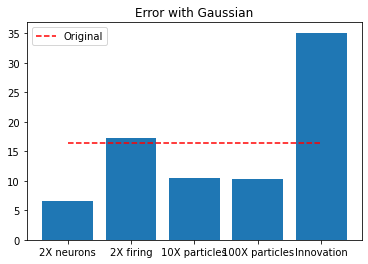

In [31]:
# Barplot graph with help from: https://www.python-graph-gallery.com/barplot/

height_gaussian = [np.mean(MSE_gaussian_2neurons), np.mean(MSE_gaussian_2firing), np.mean(MSE_gaussian_10factor),
                   np.mean(MSE_gaussian_100factor), np.mean(MSE_gaussian_innovation)]
bars = ('2X neurons', '2X firing', '10X particles', '100X particles', "Innovation")
y_pos = np.arange(len(bars))

plt.bar(y_pos, height_gaussian) # Create bars
plt.plot(y_pos, [np.mean(MSE_gaussian) for i in range(len(y_pos))], linestyle='dashed', color="r", label = "Original")

plt.xticks(y_pos, bars) # Create names on the x-axis
plt.title("Error with Gaussian")
plt.legend()
plt.show()

Now, it is easy to interpret what is happening. When we use a gaussian distribution, compared to the original set of parameters, the error is greater when the neurons fire at twice the firing rate or when incrementing 2 times the innovation term. We see an error decrease when using two times the number of neurons, or incrementing the number of particles by 10 or 100.

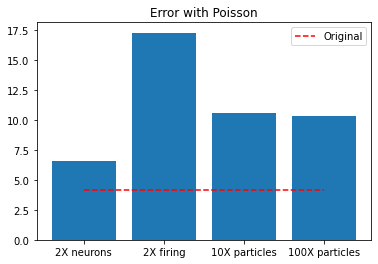

In [32]:
height_poisson = [np.mean(MSE_gaussian_2neurons), np.mean(MSE_gaussian_2firing),
                   np.mean(MSE_gaussian_10factor), np.mean(MSE_gaussian_100factor)]

bars = ('2X neurons', '2X firing', '10X particles', '100X particles')
y_pos = np.arange(len(bars))

plt.bar(y_pos, height_poisson) # Create bars
plt.plot(y_pos, [np.mean(MSE_poisson) for i in range(len(y_pos))], linestyle='dashed', color="r", label = "Original")

plt.xticks(y_pos, bars) # Create names on the x-axis
plt.title("Error with Poisson")
plt.legend()
plt.show()

Nevertheless, when using the Poisson distribution, we only see an increase in the error when changing these parameters.